# Question 4: CNN

### Importing of Libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist

train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
df = train.copy()
df_test = test.copy()

### 1. Performing Exploratory Data Analysis 

In [42]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We notice here from the examination that we have a Label attribute which is the target variable telling us the type of clothing item, while the rest of the 784 columns are pixel values.

#### Noting the Shape: We examine the shape of our dataset. Noting all the different attributes.

In [43]:
print('Training set dimensions: ', df.shape)
print('Testing set dimensions : ', df_test.shape)

Training set dimensions:  (60000, 785)
Testing set dimensions :  (10000, 785)


There are 60,000 Training Samples and 10,000 Test Samples. Each sample has 784 pixels and a single label to determine it's type. Therefore, Each Sample is a 28x28 grayscale image, associated with a label from 10 classes.

The class labels in the first column of the training samples stand in for the clothing item.

#### Label Column Analysis: we can check how many unique values this column contains.

In [44]:
df.label.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

Thus, we can check the different class label values, As we can see, they range from 0-9. Each number representing a different clothing item.

#### Missing Values: Here, we count the number of missing values. By combining the "isnull()" and "any()" functions in pandas, we can verify it.

In [45]:
df.isnull().any().sum()

0

In [46]:
df_test.isnull().any().sum()

0

Thus, as we can see that there are no missing or NaN/NULL values in any column in both test and training data set.

#### Dataset Visualization

In [47]:
# Mapping Classes
clothing_dict = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


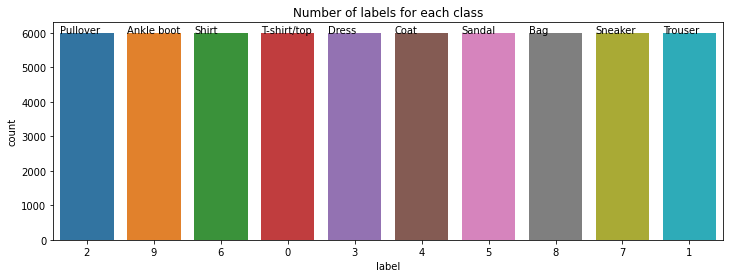

C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


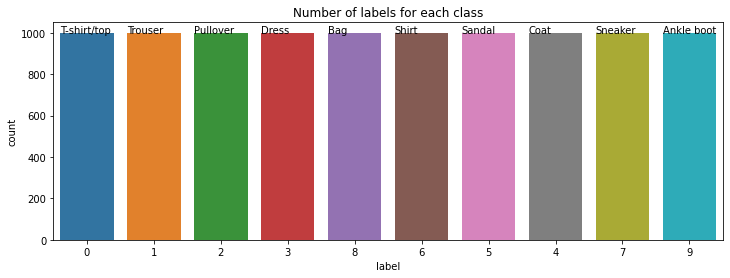

In [48]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.label, order = data["label"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(clothing_dict[label], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(df)
plot_label_per_class(df_test)

The label classes are equaly distributed in the train set and the test set (10% each). Let us confirm this using value_counts().

In [49]:
df['label'].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

In [50]:
df_test['label'].value_counts()

0    1000
1    1000
2    1000
3    1000
8    1000
6    1000
5    1000
4    1000
7    1000
9    1000
Name: label, dtype: int64

#### Let us Show a random set of FIVE (5) images from each class in the dataset with their corresponding class names.

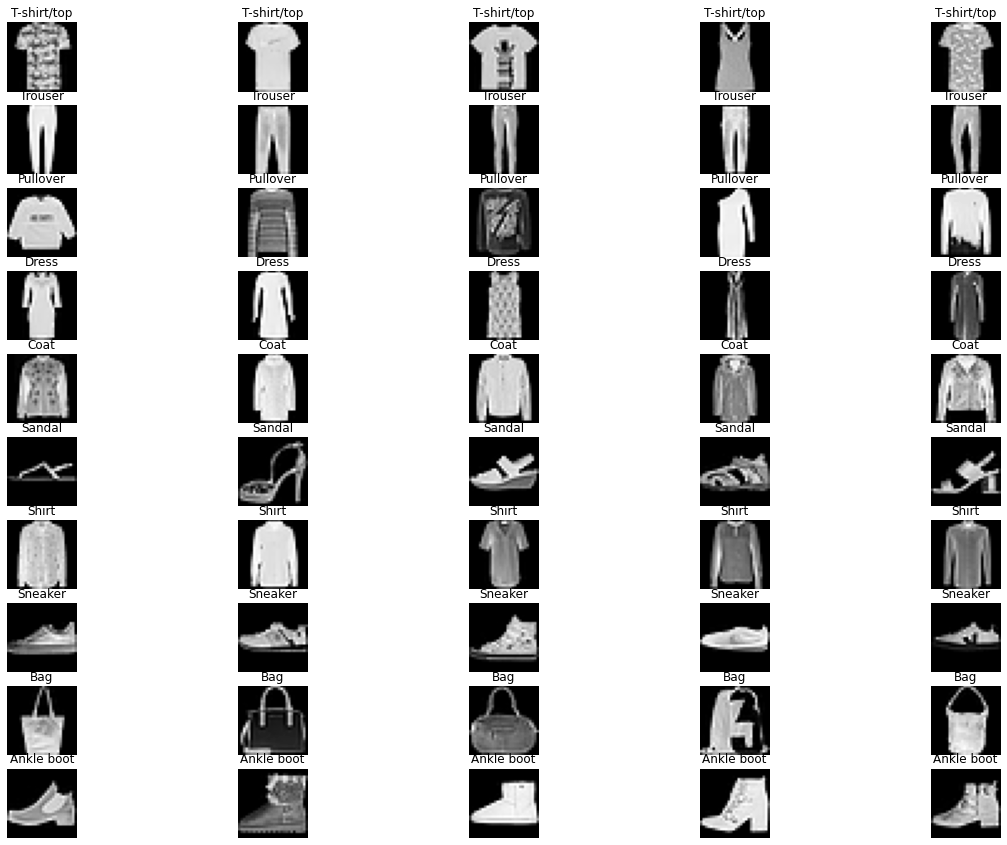

In [51]:
fig, axes = plt.subplots(10, 5, figsize = (20,15))
j=0
for row in axes:
    i = 0
    spec_df = df[df['label']==j]
    for axe in row:
        img = spec_df.drop('label', axis=1).values[i].reshape(28,28)
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing_dict[j])
        axe.set_axis_off()
        i+=1
    j+=1


### Data Pre-Processing

#### Splitting Data into Train and Validation Set

In [52]:
from sklearn.model_selection import train_test_split
#X = train.drop(['label'],axis=1).values
#Y = train['label'].values
X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2018)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(51000, 784)
(51000,)
(9000, 784)
(9000,)


#### Reshaping

Keep in mind that each of our images is a 1D vector of 784 pixels. We must transform the data into (28x28x1) 3D matrices before feeding it to the CNN.

In [53]:
# reshape(examples, height, width, channels)
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))

df_test_y = df_test.iloc[:,0]
df_test.drop('label', axis=1, inplace=True)
df_test_x = df_test.values.reshape((-1, 28, 28, 1))

#### Normalization of the Data

The range of the integer numbers used to store the pixel values is 0 to 255. They must be resized to [0,1].

In [54]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test_x = df_test_x.astype("float32")/255

#### Encoding of Labels

We one-hot-encode the target variable with 10 classes because we have 10 digits [0-9] or classes.

In [55]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
df_test_y = to_categorical(df_test_y, num_classes=10)
print(y_train.shape)
print(y_test.shape)

(51000, 10)
(9000, 10)


### Training the Convolutional Neural Network

In [56]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))



In [57]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

Now to fit our model, we use a batch size of 128, and number of epochs as 20.

In [58]:
NO_EPOCHS = 20
BATCH_SIZE = 128
train_model = model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(x_test, y_test))

Epoch 1/20
399/399 [==============================] - 24s 59ms/step - loss: 0.5261 - accuracy: 0.8108 - val_loss: 0.3789 - val_accuracy: 0.8584
Epoch 2/20
399/399 [==============================] - 24s 59ms/step - loss: 0.3409 - accuracy: 0.8776 - val_loss: 0.3194 - val_accuracy: 0.8879
Epoch 3/20
399/399 [==============================] - 24s 60ms/step - loss: 0.2916 - accuracy: 0.8937 - val_loss: 0.3203 - val_accuracy: 0.8801
Epoch 4/20
399/399 [==============================] - 24s 60ms/step - loss: 0.2606 - accuracy: 0.9049 - val_loss: 0.2949 - val_accuracy: 0.8943
Epoch 5/20
399/399 [==============================] - 25s 62ms/step - loss: 0.2359 - accuracy: 0.9133 - val_loss: 0.2774 - val_accuracy: 0.9037
Epoch 6/20
399/399 [==============================] - 24s 59ms/step - loss: 0.2103 - accuracy: 0.9224 - val_loss: 0.2677 - val_accuracy: 0.9030
Epoch 7/20
399/399 [==============================] - 24s 60ms/step - loss: 0.1916 - accuracy: 0.9295 - val_loss: 0.2547 - val_accuracy:

### Evaluation of the Model

In [59]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss percentage     :', score[0]*100)
print('Test accuracy percentage :', score[1]*100)

Test loss percentage     : 36.55807673931122
Test accuracy percentage : 91.44444465637207


#### Plotting the Model Loss and Model Accuracy Curves

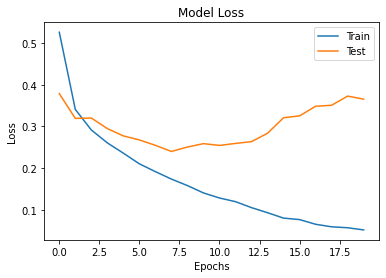

In [60]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

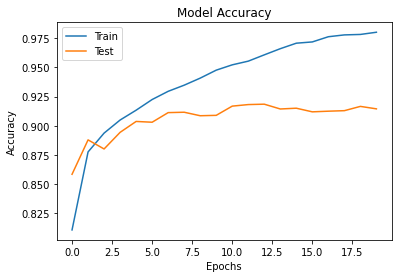

In [61]:
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

These show a clear trend where for a large dataset like the Training one, we can notice a clear increase in accuracy and decrease in loss as the number of Epochs is increased.

#### Predictions from the model

In [62]:
Y_pred = model.predict(x_test)
Y_pred = np.argmax(Y_pred,axis = 1)
Y_pred

282/282 [==============================] - 1s 4ms/step


array([6, 2, 6, ..., 0, 6, 0], dtype=int64)

In [63]:
y_test_class = np.argmax(y_test,axis = 1)
true_count = 0
total_count = len(y_test)
for i in range(0,total_count):
    if (y_test_class[i] == Y_pred[i]):
        true_count += 1

#Manual Accuracy Check
print("Accuracy is {:.2f}%".format((true_count/total_count)*100))

Accuracy is 91.44%


#### Random image Prediction Test

In [68]:
df_test_x.shape

(10000, 28, 28, 1)

We find out that there are 10000 data samples in the TEST DATASET(df_test), so we choose a random index from 0-10000.

In [66]:
index = np.random.randint(10000)

In [69]:
Y_pred = model.predict(df_test_x)
Y_pred = np.argmax(Y_pred,axis = 1)

313/313 [==============================] - 1s 4ms/step


In [71]:

image_prediction = Y_pred[index]
image_true       = np.argmax(df_test_y,axis = 1)[index]
print("Predicted label for the image using the model    : ", image_prediction)
print("Actual True value of the image                   : ", image_true)
print("Is Predicted label equal to Actual Label?      -->", image_true == image_prediction)

Predicted label for the image using the model    :  9
Actual True value of the image                   :  9
Is Predicted label equal to Actual Label?      --> True


### Conclusion:

#### Hence, We have shown that our CNN classifier correctly predicts a random image from the test dataset using pixels, most of the time. As we can see the accuracy of our model is around 91% which is quite remarkable. We have used TWO (2) convolutional layers and FOUR (4) dense layers (including the final output layer), Employed ‘ReLU’ activation and ‘MaxPooling’ while building our model. And, we kept 15% of the train dataset for validation. Finally, We evaluated the performance of the algorithm and provide the plots of accuracy & loss vs number of epochs. 